In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
import joblib
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from IPython.utils import io
from multiprocessing import Pool

%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *
from stacking.stacking import Stacking

In [2]:
sigmas = ["0.0000", "0.0004", "0.0007", "0.0012", "0.0021", "0.0037", "0.0065", "0.0114",
          "0.0199", "0.0348", "0.0609", "0.1066", "0.1866", "0.3265", "0.5714", "1.0000"]

def get_data(sigma):
    return [
        ('134325_4611969',
         'CASP 5-10',
         'residue dependent backbone',
         ['*residues-d4-b10-a12-c5-n0-s{}--skip_errors.mat'.format(sigma),
          '*hbonds-b6-a6-c6-n2-s{}--skip_errors.mat'.format(sigma),
          '*solvation-b3-a2-c15-s{}--skip_errors.mat'.format(sigma),
          '*backboneatom-b25-c7-n0-s{}--residue_type_dependent--skip_errors.mat'.format(sigma)]),
    ]

model = 'models/ridge_pipeline'

# Load assessors

In [3]:
def test_assessor(args):
    (sigma, training_set_shape,
     training_set, featurization, features,
     checksums, subset_pattern) = args
    try:
        assessor = joblib.load('{}_{}.pkl'.format(model, training_set_shape))
        normalizers = assessor.steps[0][1].normalizers
        pipeline = assessor.steps[1][1]

        with io.capture_output() as captured:
            X_test, scores_test = get_dataset(
                [(dataset, checksum, normalizer.transform)
                     for dataset, checksum, normalizer in zip(features, checksums, normalizers)],
                subset_pattern
            )

        natives_included = scoring_results(X_test, scores_test,
                                           lambda X: pipeline.predict(X),
                                           num_plots=0)[0]['GDT-TS-score']

        natives_excluded = scoring_results(X_test[~get_natives(scores_test).values],
                                           scores_test[~get_natives(scores_test).values],
                                           lambda X: pipeline.predict(X),
                                           num_plots=0)[0]['GDT-TS-score']

        return training_set, featurization, sigma, natives_included, natives_excluded
    except Exception as e:
        return training_set, featurization, sigma, pd.Series(), pd.Series()

def to_df(training_set, featurization, sigma, records):
    df = pd.concat(records, axis=1).T
    df.insert(0, 'Sigma', sigma)
    df.insert(0, 'Features', featurization)
    df.insert(0, 'Training set', training_set)
    return df[~df.isnull().any(1)]


def test_assessors(checksums, subset_pattern, num_jobs=20):
    pool = Pool(num_jobs)
    results = pool.map(test_assessor, [(sigma, training_set_shape,
                                        training_set, featurization, features,
                                        checksums, subset_pattern)
                                         for sigma in sorted(sigmas)
                                         for training_set_shape, training_set, featurization, features in get_data(sigma)])
    training_set, featurization, sigma, records_natives_included, records_natives_excluded = zip(*results)

    return (to_df(training_set, featurization, sigma, records_natives_included),
            to_df(training_set, featurization, sigma, records_natives_excluded))

# Test assessors

## CASP10

In [4]:
results_natives_included, results_natives_excluded = test_assessors(
    ['ef3274a90fe9e1f76f6a24c0a68f2ad1',
     'ef3274a90fe9e1f76f6a24c0a68f2ad1',
     'ef3274a90fe9e1f76f6a24c0a68f2ad1',
     'ef3274a90fe9e1f76f6a24c0a68f2ad1'],
    '^.*CASP10Stage[12]/T..../.*$',
    num_jobs=10
)

#### excluding native

In [5]:
results_natives_excluded

Training set                    Features   Sigma  \
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0000   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0004   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0007   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0012   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0021   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0037   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0065   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0114   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0199   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0348   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.0609   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.1066   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.1866   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.3265   
GDT-TS-score    CASP 5-10  residue dependent backbone  0.5714   
GDT-TS-score    CASP 5-10  residue dependent backbone  1.0000   

             Mean rank of the native     Top 1     Top 5 Mean score for top 1  \
GDT-TS-score                 19.4951   0.11165  0.417476             0.579447   
GDT-TS-score                 19.5631  0.116505  0.417476             0.579988   
GDT-TS-score                 19.5777  0.121359   0.42233             0.580093   
GDT-TS-score                 19.5583  0.121359   0.42233             0.580329   
GDT-TS-score                 19.5485  0.121359   0.42233             0.579082   
GDT-TS-score                 19.5097  0.116505  0.412621             0.578758   
GDT-TS-score                 19.4175  0.126214  0.407767             0.577269   
GDT-TS-score                  19.034  0.126214  0.402913             0.579429   
GDT-TS-score                 18.5388  0.126214  0.417476             0.576643   
GDT-TS-score                  18.233  0.135922  0.412621              0.57913   
GDT-TS-score                 17.7621  0.140777  0.417476              0.58194   
GDT-TS-score                 17.4175  0.140777  0.427184             0.583473   
GDT-TS-score                 17.2379  0.140777   0.42233              0.58546   
GDT-TS-score                 17.0388  0.145631  0.436893             0.585361   
GDT-TS-score                 16.9515  0.140777  0.432039              0.58376   
GDT-TS-score                 16.9126  0.145631  0.436893              0.58395   

             Mean loss score Mean Pearson Mean Spearman Mean Kendall tau  \
GDT-TS-score       0.0589461     -0.46525     -0.437287        -0.314774   
GDT-TS-score       0.0584049    -0.465418     -0.437033        -0.314472   
GDT-TS-score       0.0583005    -0.465438     -0.437053        -0.314475   
GDT-TS-score       0.0580646    -0.465456     -0.437077        -0.314491   
GDT-TS-score       0.0593112    -0.465527      -0.43729        -0.314182   
GDT-TS-score       0.0596354     -0.46574     -0.437611        -0.314804   
GDT-TS-score       0.0611238    -0.466162     -0.438736        -0.315683   
GDT-TS-score       0.0589646    -0.466479     -0.439911        -0.316115   
GDT-TS-score       0.0617505    -0.467837     -0.443011        -0.317872   
GDT-TS-score       0.0592631      -0.4705      -0.44665        -0.320669   
GDT-TS-score       0.0564529     -0.47209     -0.449879        -0.323555   
GDT-TS-score       0.0549199    -0.472396     -0.450652        -0.324598   
GDT-TS-score       0.0529335    -0.472531     -0.451183        -0.325501   
GDT-TS-score       0.0530325    -0.472409     -0.449303        -0.324552   
GDT-TS-score        0.054633     -0.47191     -0.448297         -0.32434   
GDT-TS-score       0.0544432    -0.471563     -0.447185        -0.323748   

                  PMCC      SMCC    wmPMCC    wmSMCC Mean Z-score  
GDT-TS-score -0.234621 -0.243398 -0.523506 -0.473984     0.819798  
GDT-TS-score -0.234844 -0.243575 -0.523794 -0.473549     0.827681  
GDT-TS-score -0.234955 -0.243661

## Plot

In [6]:
csv_name = 'smoothing_results.csv'
results_natives_excluded.to_csv(csv_name)

x = pd.DataFrame.from_csv(csv_name)

In [7]:
x = results_natives_excluded

In [8]:
df = -x[['Mean Pearson', 'Mean Spearman', 'Mean Kendall tau', 'Mean loss score']]
df.index = x.Sigma.astype(float)
df / df.iloc[0]

Mean Pearson Mean Spearman Mean Kendall tau Mean loss score
Sigma                                                             
0.0000            1             1                1               1
0.0004      1.00036      0.999419         0.999042        0.990818
0.0007       1.0004      0.999466          0.99905        0.989047
0.0012      1.00044       0.99952         0.999102        0.985045
0.0021       1.0006       1.00001          0.99812         1.00619
0.0037      1.00105       1.00074          1.00009         1.01169
0.0065      1.00196       1.00331          1.00289         1.03694
0.0114      1.00264         1.006          1.00426         1.00031
0.0199      1.00556       1.01309          1.00984         1.04758
0.0348      1.01128       1.02141          1.01873         1.00538
0.0609       1.0147        1.0288           1.0279        0.957704
0.1066      1.01536       1.03056          1.03121        0.931697
0.1866      1.01565       1.03178          1.03408        0.897998
0.3265      1.01539       1.02748          1.03106        0.899678
0.5714      1.01431       1.02518          1.03039         0.92683
1.0000      1.01357       1.02264          1.02851         0.92361

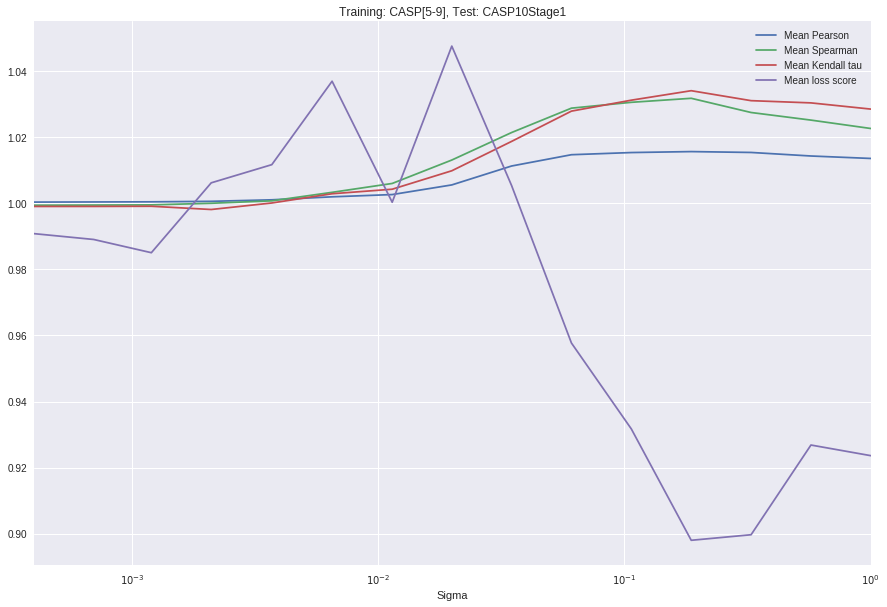

In [9]:
(df / df.iloc[0]).plot(logx=True, figsize=(15, 10))
plt.title('Training: CASP[5-9], Test: CASP10Stage1')
plt.show()